In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
os.chdir(r"..\datasets")

In [3]:
drop_columns = ['geoId', 'countryterritoryCode', 'day', 'month', 'year']

<p style="color:red;">To make the model more generic to other countries I would suggest we need to give the model some understanding other differneces between china and other contries</p>

In [4]:
#target_country = "China"

In [5]:
# Import and format dataframe
covid19_df = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-03-31.csv', engine='python')

In [6]:
covid19_df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,31/03/2020,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
1,30/03/2020,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0
2,29/03/2020,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
3,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
4,27/03/2020,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0


In [7]:
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
covid19_df.drop(columns=drop_columns, inplace=True)
covid19_df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018
0,2020-03-31,27,0,Afghanistan,37172386.0
1,2020-03-30,8,1,Afghanistan,37172386.0
2,2020-03-29,15,1,Afghanistan,37172386.0
3,2020-03-28,16,1,Afghanistan,37172386.0
4,2020-03-27,0,0,Afghanistan,37172386.0


In [8]:
# Create df for one country
#country_df = covid19_df.loc[covid19_df.countriesAndTerritories == "China"].copy()

country_df = covid19_df.copy() 
country_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
country_df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018
2579,2019-12-31,0,0,Finland,5518050.0
1450,2019-12-31,0,0,Cases_on_an_international_conveyance_Japan,3000.0
2130,2019-12-31,0,0,Dominican_Republic,10627165.0
2897,2019-12-31,0,0,Germany,82927922.0
6070,2019-12-31,0,0,Qatar,2781677.0


<p style="color:red">Because this dataframe is not specific to china (aka we have other contries in here) we can no longer do a simple cumsum on the cases and deaths becasue 
this will create a running total over all countries as opposed to just the one. To get around this we can use a pandas groupby. Groupbys are really usefull, basically what they do is create a 
series of small dataframes. So in this case we want to groupby <b>"countriesAndTerritories"</b>. What this groupby will do is it will create a temoporary mini dataframe for each unique country in the <b>"countriesAndTerritories"</b> column, in a sort of forloop fassion. Once we have the groupby dataframe we want to grab the relevant column and apply the cumsum() function. This way we make sure we're not creating a running total over differnt countries rather the cumultive sum is spcific to a given country</p>

In [9]:
# Add cumulative columns for cases and deaths
# country_df['Cum Cases'] = country_df['cases'].cumsum()
# country_df['Cum Deaths'] = country_df['deaths'].cumsum()
country_df['Cum Cases'] = country_df.groupby("countriesAndTerritories")['cases'].cumsum()
country_df['Cum Deaths'] = country_df.groupby("countriesAndTerritories")['deaths'].cumsum()
country_df.head()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,Cum Cases,Cum Deaths
2579,2019-12-31,0,0,Finland,5518050.0,0,0
1450,2019-12-31,0,0,Cases_on_an_international_conveyance_Japan,3000.0,0,0
2130,2019-12-31,0,0,Dominican_Republic,10627165.0,0,0
2897,2019-12-31,0,0,Germany,82927922.0,0,0
6070,2019-12-31,0,0,Qatar,2781677.0,0,0


<p style="color:red">Hwe we have the same issue as above. We want to count the number of days since the 100th. But this will now be different for each country so again we need to apply a groupby</p>

In [10]:
# Create column for days since x deaths
country_df['flag'] = np.where(country_df['Cum Cases'] > 100, 1, 0) # this is fine to calculate globaly as its a true false, no agregaton at this stage

# Here I use the same logic as you. I filter the dataframe on cases (impartant to note i'm only filtering the grouped by dataframe). I then groupby the countriesAndTerritories
# column (again creating a unique dataframe for each country) and applying a cumulative sum to the "flag" column
country_df['flag'] = country_df.loc[country_df['Cum Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

In [11]:
# as you can see because the groupby filtered out rows where cases were less than 100 the flag is now showing NaN values. All I do here is fill these nans with 0
country_df[country_df.countriesAndTerritories =="China"].iloc[15:25]

,dateRep,cases,deaths,countriesAndTerritories,popData2018,Cum Cases,Cum Deaths,flag
1594,2020-01-15,0,1,China,1.392730e+09,59,2,NaN
1593,2020-01-16,0,0,China,1.392730e+09,59,2,NaN
1592,2020-01-17,4,0,China,1.392730e+09,63,2,NaN
1591,2020-01-18,17,0,China,1.392730e+09,80,2,NaN
1590,2020-01-19,136,1,China,1.392730e+09,216,3,1.0
1589,2020-01-20,19,0,China,1.392730e+09,235,3,2.0
1588,2020-01-21,151,3,China,1.392730e+09,386,6,3.0
1587,2020-01-22,140,11,China,1.392730e+09,526,17,4.0
1586,2020-01-23,97,0,China,1.392730e+09,623,17,5.0
1585,2020-01-24,259,9,China,1.392730e+09,882,26,6.0


In [12]:
country_df.flag.fillna(0, inplace=True) # fill the nans in the flag column as a reult of mergining in the filtered groupby

<p style="color:red">As we now want to gernerate a model which is aware of other countries we need to convert this column to numeric fields which the model can understand. Do do this we use <b>pd.get_dummies</b> to create a series of categorical (dummy) variables</p>

In [13]:
# I'll store the new dataframe as a new vairable so we can refer back to the dataframe above, country_df

# first drop the columns we dont want, becasue once we have the dummy/ categorical columns it gets harder to work out which cols to keep
df_model = country_df.drop(columns=["dateRep", "cases", "deaths", "popData2018"]) 
df_model.head()

,countriesAndTerritories,Cum Cases,Cum Deaths,flag
2579,Finland,0,0,0.0
1450,Cases_on_an_international_conveyance_Japan,0,0,0.0
2130,Dominican_Republic,0,0,0.0
2897,Germany,0,0,0.0
6070,Qatar,0,0,0.0


In [14]:
# now we get the dummy variables/ categroical variables for the countriesAndTerritories column
df_model = pd.get_dummies(df_model, columns=["countriesAndTerritories"])
df_model.head() # remember for each row only one of the categorical columns have the value 1 all the rest are 0. This tells the model which country the entry is for

,Cum Cases,Cum Deaths,flag,countriesAndTerritories_Afghanistan,countriesAndTerritories_Albania,countriesAndTerritories_Algeria,countriesAndTerritories_Andorra,countriesAndTerritories_Angola,countriesAndTerritories_Anguilla,countriesAndTerritories_Antigua_and_Barbuda,...,countriesAndTerritories_United_Kingdom,countriesAndTerritories_United_Republic_of_Tanzania,countriesAndTerritories_United_States_Virgin_Islands,countriesAndTerritories_United_States_of_America,countriesAndTerritories_Uruguay,countriesAndTerritories_Uzbekistan,countriesAndTerritories_Venezuela,countriesAndTerritories_Vietnam,countriesAndTerritories_Zambia,countriesAndTerritories_Zimbabwe
2579,0,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,0,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2130,0,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2897,0,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6070,0,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_model["tempCountry"] = country_df["countriesAndTerritories"]

In [16]:
def split_data(df, split_frac, data_type="test"):
    test_rows = int(np.floor(len(df) * split_frac))
    test_index = len(df) - test_rows
    if data_type == "test":
        df = df.iloc[test_index:, :]
    elif data_type == "train":
        df = df.iloc[:test_index,:]
    return df

In [17]:
test_split =0.3

<h3>Discrete approach tp train test sampling</h3>
<p>try sampling the last fraction of data from each country</p>

In [18]:
df_model_test = df_model.groupby("tempCountry", as_index= False).apply(lambda x: split_data(x, test_split, "test"))
df_model_train = df_model.groupby("tempCountry", as_index=False).apply(lambda x: split_data(x, test_split, "train"))

In [19]:
df_model_train.index = [i for i in range(len(df_model_train))]
df_model_test.index = [i for i in range(len(df_model_test))]

In [20]:
# Create series for days vs cases

# X = country_df.iloc[:, 7:8]
# y = country_df.iloc[:, 5:6]
country_cols = [i for i in list(df_model) if "countriesAndTerritories" in i] # use list comprehenssion to get a list of all the categorical columns and the order they appear in

training_cols = ["flag"] + country_cols # add the flag column back into the list of features for the model

In [21]:
X_train = df_model_train[training_cols]
X_test = df_model_test[training_cols]
y_train = df_model_train["Cum Cases"]
y_test = df_model_test["Cum Cases"]


In [22]:
# Fit linear relationship
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# create new column in dataframe for linear prediction
X_test["linearPred"]= lin_reg.predict(X_test)
X_train["linearPred"]= lin_reg.predict(X_train)

C:\Users\DR25798\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\DR25798\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [23]:
# Fit polynomial relationship
# poly_reg = PolynomialFeatures(degree = 9)
# X_poly = poly_reg.fit_transform(X_train)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, GridSearchCV

In [24]:
# poly_reg.fit(X_poly, y)
# lin_reg_2 = LinearRegression()
# lin_reg_2.fit(X_poly, y)

In [25]:
params = {"n_estimators": [50,100,150,200],
         "max_depth": [5,10,15,20], 
         "min_samples_split": [2,3,5]}

In [26]:
rf= RandomForestRegressor(verbose=1, n_jobs=-1)

In [33]:
cv= GridSearchCV(estimator=rf,
                 param_grid=params,
                 cv=10,
                 scoring="neg_median_absolute_error",
                 verbose=1,
                 n_jobs=-1)

In [28]:
model = cv.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  7.6min finished
C:\Users\DR25798\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished


In [29]:
df_model_train["rf_prediction"] = model.predict(X_train)
df_model_test["rf_prediction"] = model.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


In [41]:
import pickle as pkl

In [38]:
pkl.dump(model, open("rf_cases.pkl", "wb"))

In [39]:
top_count = df_model_test.tempCountry.value_counts().iloc[:20]

In [40]:
countries_in_both = [i for i in top_count.keys() if i in df_model_test.tempCountry.tolist()]

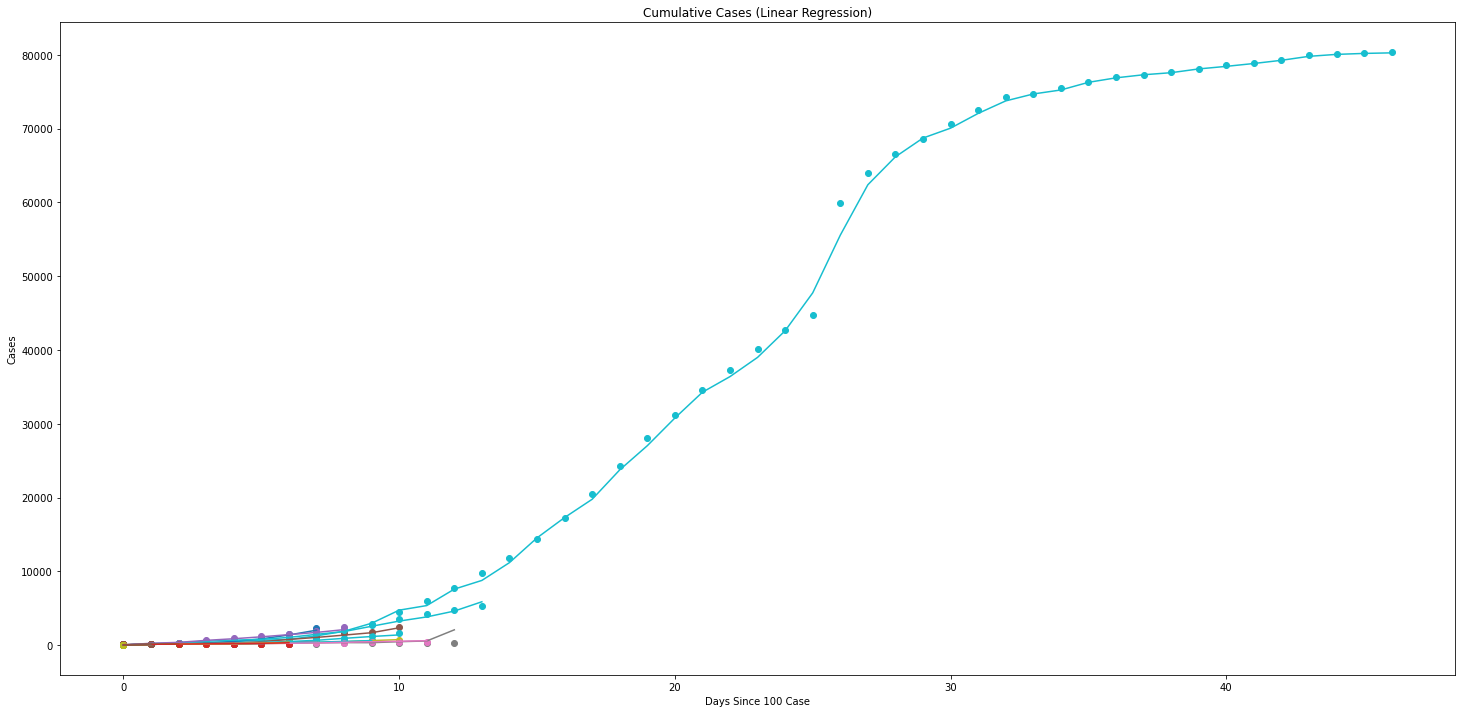

In [41]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in df_model_train.tempCountry.unique():
    plt.scatter(df_model_train[df_model_train["tempCountry"] == country]["flag"],
                df_model_train[df_model_train["tempCountry"] == country]["Cum Cases"],
                marker="o", label=f"{country} train actual cases")
#     plt.scatter(X_test[X_test["countryName"] == country]["flag"], X_test[X_test["countryName"] == country]["actualCases"], marker="x", label= f"{country} test actual cases")
    
    plt.plot(df_model_train[df_model_train["tempCountry"] == country]["flag"],
             df_model_train[df_model_train["tempCountry"] == country]["rf_prediction"], label=f"{country} train actual cases")
#     plt.plot(X_test[X_test["countryName"] == country]["flag"], X_test[X_test["countryName"] == country]["rf_prediction"])
plt.title('Cumulative Cases (Linear Regression)')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Cases')
plt.show()


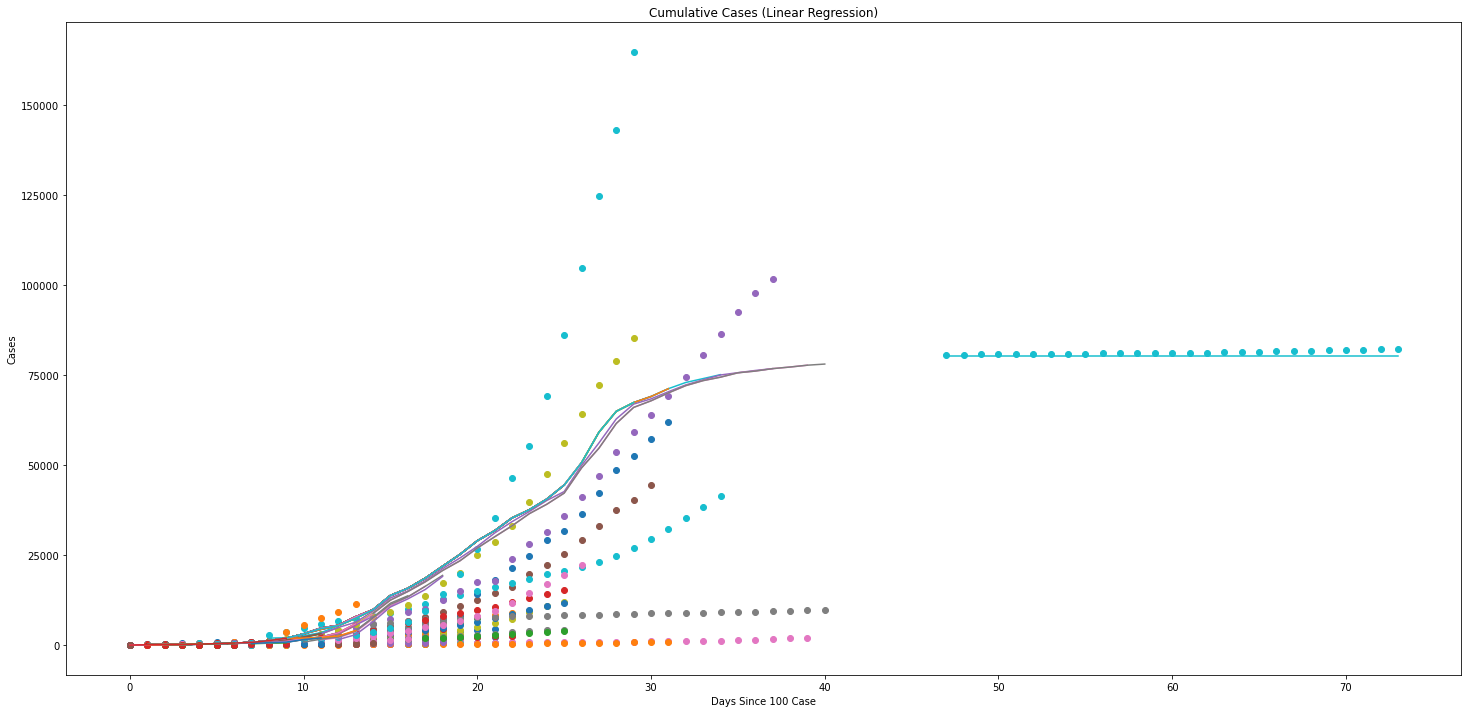

In [42]:
# Visualising the Linear Regression results
plt.figure(figsize=(25, 12))
for country in df_model_test.tempCountry.unique():
    plt.scatter(df_model_test[df_model_test["tempCountry"] == country]["flag"],
                df_model_test[df_model_test["tempCountry"] == country]["Cum Cases"],
                marker="o", label=f"{country} train actual cases")
    
    plt.plot(df_model_test[df_model_test["tempCountry"] == country]["flag"],
             df_model_test[df_model_test["tempCountry"] == country]["rf_prediction"])
plt.title('Cumulative Cases (Linear Regression)')
plt.xlabel('Days Since 100 Case')
plt.ylabel('Cases')
plt.show()


<h3>Classic train test split approach</h3>
<p>Compare results against the above train test samples</p>

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
df_model["tempCountry"] = country_df["countriesAndTerritories"]

In [36]:
keep_cols = ["flag", "tempCountry"]+[i for i in list(df_model) if "countriesAndTerritories" in i]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_model[keep_cols], df_model["Cum Cases"], test_size=0.3, random_state=42)

In [38]:
X_train_country = X_train["tempCountry"]
X_test_country = X_test["tempCountry"]

X_train.drop(columns="tempCountry", inplace=True)
X_test.drop(columns="tempCountry", inplace=True)

In [39]:
model_2 = cv.fit(X_train, y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 12.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [45]:
pkl.dump(model_2,open("rf_cases_trainsplit.pkl", "wb"))

In [46]:
X_train["rf_prediction"] = model_2.predict(X_train)
X_test["rf_prediction"] = model_2.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [47]:
X_train["tempCountry"] = X_train_country
X_test["tempCountry"] = X_test_country

X_train["Cum Cases"] = y_train
X_test["Cum Cases"] = y_test

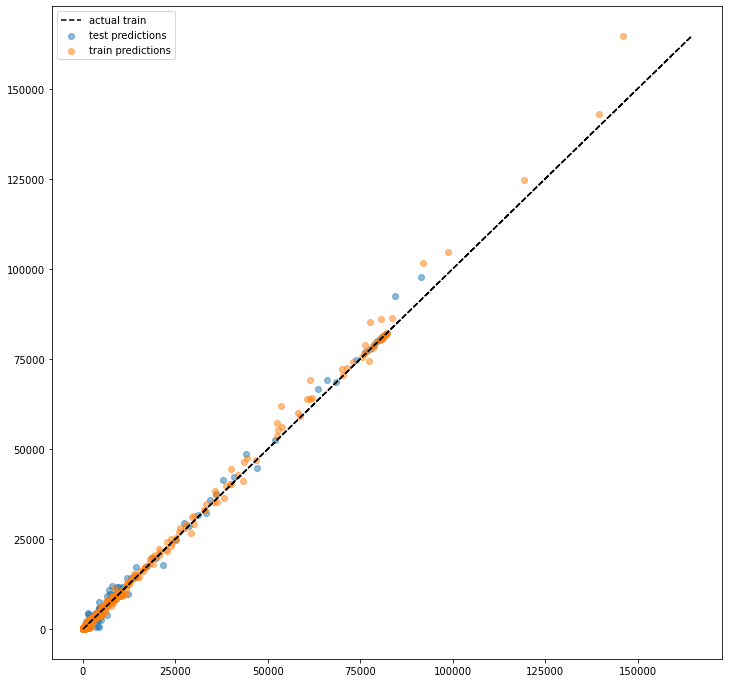

In [58]:
plt.figure(figsize=(12, 12))
plt.scatter(X_test.rf_prediction, X_test["Cum Cases"], alpha=0.5, label="test predictions")
plt.scatter(X_train.rf_prediction, X_train["Cum Cases"], alpha=0.5, label="train predictions")
plt.plot(X_train["Cum Cases"], X_train["Cum Cases"], label="actual train", linestyle="--", color="black")
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [50]:
mean_absolute_error(X_test.rf_prediction, X_test["Cum Cases"])

96.95909181340896

In [51]:
mean_absolute_error(X_train.rf_prediction, X_train["Cum Cases"])

77.708000177371

In [52]:
median_absolute_error(X_test.rf_prediction, X_test["Cum Cases"])

8.692532376240733

In [53]:
median_absolute_error(X_train.rf_prediction, X_train["Cum Cases"])

8.692532376240733